In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision

from PIL import Image
from matplotlib import pyplot as plt
device = "cuda" if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
vgg_model = torchvision.models.vgg19(weights = 'DEFAULT').features

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:04<00:00, 121MB/s]


In [4]:
vgg_model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

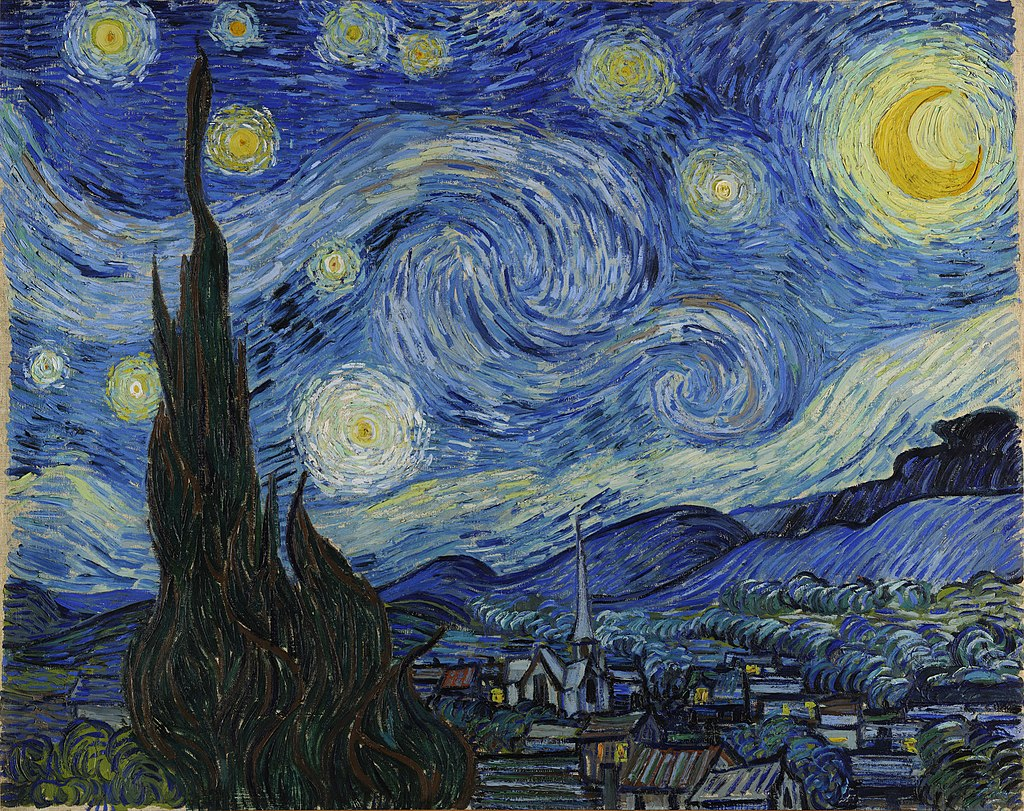

In [5]:
style_image = Image.open('/content/drive/MyDrive/DL/Neural Style Transfer/Starry_Night.jpeg')
style_image

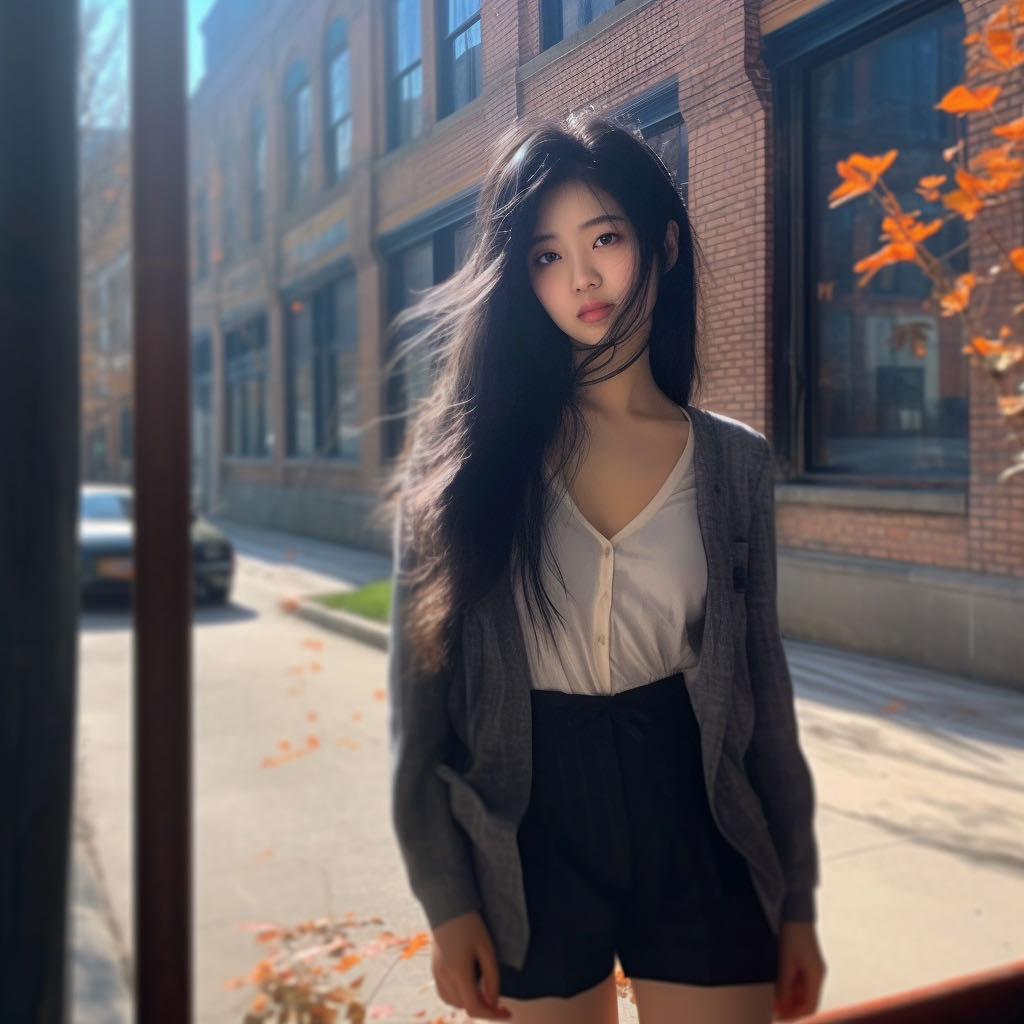

In [6]:
content_image = Image.open('/content/drive/MyDrive/DL/Neural Style Transfer/content.jpeg')
content_image


In [7]:
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

def preprocess(img, image_shape = (224,224), device = device):
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(image_shape),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=mean, std=std)])
    return transforms(img).unsqueeze(0).to(device)

In [8]:
content_img = preprocess(content_image)
style_img = preprocess(style_image)
generated_img = content_img.clone().requires_grad_(True)

In [9]:
print(content_img.shape)
print(style_img.shape)
print(generated_img.shape)

torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])


In [10]:
class NST_VGG(nn.Module):
  def __init__(self):
    super(NST_VGG, self).__init__()
    self.style_layers = [0, 5, 10, 19, 28]
    self.content_layers = [25]
    self.model = vgg_model

  def forward(self, x):
    contents = []
    styles = []
    for layer_num, layer in enumerate(self.model):
        x = layer(x)
        if layer_num in self.style_layers:
            styles.append(x)
        if layer_num in self.content_layers:
            contents.append(x)

    return contents, styles

In [11]:
def content_loss(content, generated):
  return torch.square(content.detach() - generated).mean()

def gram(img):
  batch_size, channel, height, width = img.shape
  img = img.reshape((batch_size * channel, height * width))
  return torch.matmul(img, img.T) / (batch_size * channel * height * width )

def style_loss(style, generated):
  return torch.square(gram(style).detach() - gram(generated)).mean()

def total_variation_loss(img):
  a = torch.abs(img[:,:,1:,:] - img[:,:,:-1,:]).mean()
  b = torch.abs(img[:,:,:,1:] - img[:,:,:,:-1]).mean()

  return 0.5 * ( a + b)

In [12]:
def total_loss(generated_img, content_y_hat, style_y_hat, content_y, style_y):
  content_weight = 0.001
  style_weight = 1000
  total_variation_weight = 0.01

  cl = sum([content_loss(x, y) for (x, y) in zip(content_y, content_y_hat)])
  sl = sum([style_loss(x, y) for (x, y) in zip(style_y, style_y_hat)])
  tl = total_variation_loss(generated_img)

  total_loss = cl * content_weight + sl * style_weight + tl * total_variation_weight

  return cl * content_weight , sl * style_weight , tl * total_variation_weight, total_loss

In [13]:
def train(generated_img,
          content_img,
          style_img,
          model,
          lr = 0.1,
          num_epochs = 5000 ,
          lr_decay_epoch = 50):

  optimizer = torch.optim.Adam([generated_img], lr=lr)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_decay_epoch, 0.8)

  content_y , _ = model(content_img)
  _ , style_y   = model(style_img)

  cl_list = []
  sl_list = []
  tl_list = []
  total_list = []

  for epoch in range(num_epochs):
    optimizer.zero_grad()

    content_y_hat, style_y_hat = model(generated_img)

    cl , sl , tl , l = total_loss(generated_img, content_y_hat, style_y_hat, content_y, style_y)

    cl_list.append(cl.item())
    sl_list.append(sl.item())
    tl_list.append(tl.item())
    total_list.append(l.item())

    l.backward()
    optimizer.step()
    scheduler.step()

    if (epoch + 1 ) % 10 == 0:
      #plt.imshow(postprocess(generated_img))
      save_image(generated_img,"gen.png")

  return generated_img, cl_list, sl_list, tl_list, total_list

In [14]:
model=NST_VGG().to(device).eval()

In [15]:
def postprocess(img, device = device):
    img = img[0].to('cpu')
    img = torch.clamp(img.permute(1, 2, 0) * std + mean, 0, 1)
    return torchvision.transforms.ToPILImage()(img.permute(2, 0, 1))

from torchvision.utils import save_image

In [16]:
generated_img, cl_list, sl_list, tl_list, total_list = train( generated_img,
                                                            content_img,
                                                            style_img,
                                                            model,
                                                            lr = 0.1,
                                                            num_epochs = 500,
                                                            lr_decay_epoch = 50)

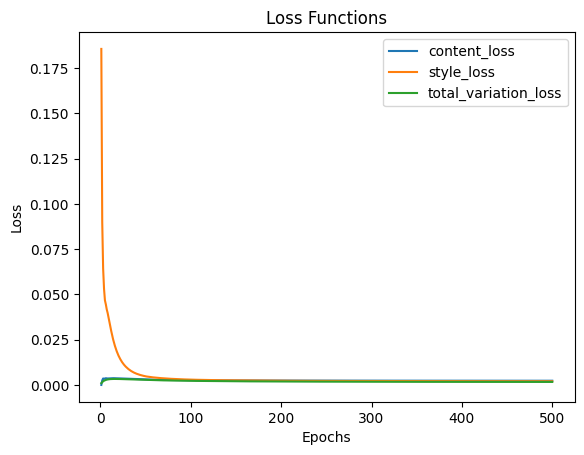

In [17]:
epochs = list(range(1, 501))

# Plot the loss functions
plt.plot(epochs, cl_list, label='content_loss')
plt.plot(epochs, sl_list, label='style_loss')
plt.plot(epochs, tl_list, label='total_variation_loss')

# Set labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Functions')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [21]:
print('content loss: ', cl_list[-1])
print('style loss: ', sl_list[-1])
print('total variation loss: ', tl_list[-1])
print('total loss: ', total_list[-1])

content loss:  0.0023148932959884405
style loss:  0.002025921829044819
total variation loss:  0.001648472505621612
total loss:  0.005989287979900837


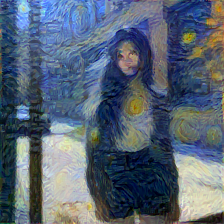

In [18]:
postprocess(generated_img)